Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Sanjiv Murthy"
COLLABORATORS = ""

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
import zipfile
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from utils import timeit

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

In [3]:
# Loading Part 1

!ls -lh /srv/db/taxi_2016_student_small.sqlite

DB_URI = "sqlite:////srv/db/taxi_2016_student_small.sqlite"
TABLE_NAME = "taxi"

sql_engine = create_engine(DB_URI)
with timeit():
    print(f"Table {TABLE_NAME} has {sql_engine.execute(f'SELECT COUNT(*) FROM {TABLE_NAME}').first()[0]} rows!")
    

-rw-r--r-- 1 root root 2.1G Nov  7 04:43 /srv/db/taxi_2016_student_small.sqlite
Table taxi has 15000000 rows!
1.05 s elapsed


In [4]:
# Using month of April as training set 

q1d_query = f"""
            SELECT * 
            FROM taxi
            WHERE tpep_pickup_datetime
                BETWEEN '2016-04-01' AND '2016-05-01'
                AND record_id % 100 == 0
            ORDER BY tpep_pickup_datetime
            """

# YOUR CODE HERE
# raise NotImplementedError()
with timeit(): # This query should take less than 3 second
    apr_16 = pd.read_sql_query(q1d_query, sql_engine)
apr_16['tpep_dropoff_datetime'] = pd.to_datetime(apr_16["tpep_dropoff_datetime"])
apr_16['tpep_pickup_datetime'] = pd.to_datetime(apr_16["tpep_pickup_datetime"])

2.89 s elapsed


In [5]:
## Cleaning
cleaned_apr_16 = apr_16.copy()

# limiting rides < 0.5 day

cleaned_apr_16['duration'] = cleaned_apr_16["tpep_dropoff_datetime"]-cleaned_apr_16["tpep_pickup_datetime"]
cleaned_apr_16['duration'] = cleaned_apr_16['duration'].dt.total_seconds()
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['duration'] < 12 * 3600]

# limiting to rides in NYC

cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['pickup_longitude'] <= -73.75]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['pickup_longitude'] >= -74.03]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['pickup_latitude'] <= 40.85]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['pickup_latitude'] >= 40.63]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['dropoff_longitude'] <= -73.75]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['dropoff_longitude'] >= -74.03]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['dropoff_latitude'] <= 40.85]
cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['dropoff_latitude'] >= 40.63]

# limiting to rides with > 0 passengers

cleaned_apr_16 = cleaned_apr_16[cleaned_apr_16['passenger_count'] > 0]


In [6]:
## Adding Temporal Features

def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False 
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
 
    # No real need to return here, but we harmonize with remove_outliers for later pipelinezation
    return df

short_rides = cleaned_apr_16[cleaned_apr_16["duration"] <= 900] # rides less than or equal to 15 mins
long_rides = cleaned_apr_16[cleaned_apr_16["duration"] > 900] # rides more than 15 minutes

cleaned_apr_16 = add_time_columns(cleaned_apr_16)
short_rides = add_time_columns(short_rides)
long_rides = add_time_columns(long_rides)


/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [7]:
## Adding distance features

# These functions are implemented for you

# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

cleaned_apr_16 = add_distance_columns(cleaned_apr_16)
short_rides = add_distance_columns(short_rides)
long_rides = add_distance_columns(long_rides)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [8]:
# calculating mae

def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae


In [9]:
# testing guided model

# Run this cell to load the data. 
data_file = Path("./", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")
val_df = pd.read_hdf(data_file, "val")
test_df = pd.read_csv("./proj2_test_data.csv")
test_df['tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])


# processing data for cleaned_apr_16
def process_data_gm1(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        .pipe(select_columns,        
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'trip_distance',
              'manhattan',
              'fare_amount',
              'mta_tax',
              'tip_amount',
              'tolls_amount',
              'improvement_surcharge',
              'total_amount',
              'month',
              'week_of_year',
              'day_of_month',
              'day_of_week',
              'hour',
              'week_hour',
              'bearing',
              'haversine'
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y

In [10]:
# Do test train split on cleaned_apr_16
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(cleaned_apr_16, test_size=0.2, random_state=42)

In [11]:
# Train and Predict Model

X_train, y_train = process_data_gm1(train_df)
X_val, y_val = process_data_gm1(val_df)
final_model_1 = lm.LinearRegression(fit_intercept=True)
final_model_1.fit(X_train, y_train)

# Predict
y_train_pred = final_model_1.predict(X_train)
y_val_pred = final_model_1.predict(X_val)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [12]:
X_test,y_test = process_data_gm1(test_df, test=True)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [13]:
## Removing zeros in test set
zeros = ['pickup_longitude','pickup_latitude','trip_distance','dropoff_longitude','dropoff_latitude','manhattan','bearing','haversine']
for i in zeros:
    zero_rows = X_test[X_test.loc[:,i] == 0].loc[:,i].index
#     print(i)
    X_test.loc[zero_rows, i] = np.mean(X_train[i])
X_test.head(10)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,manhattan,fare_amount,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,week_of_year,day_of_month,day_of_week,hour,week_hour,bearing,haversine
0,-73.982224,40.768620,-73.983765,40.779598,1.20,1.350561,6.0,0.5,2.00,0.00,0.3,9.30,1,53,2,5,1,121,-6.067525,1.227654
1,-73.999977,40.738121,-73.888657,40.824364,10.90,18.968770,31.5,0.5,6.56,0.00,0.3,39.36,1,53,2,5,3,123,44.308599,13.409519
2,-73.986618,40.747379,-73.978508,40.729622,1.80,2.657731,8.5,0.5,1.96,0.00,0.3,11.76,1,53,2,5,3,123,160.909187,2.089418
3,-74.002922,40.744572,-73.942413,40.786419,5.95,9.750712,20.5,0.5,4.36,0.00,0.3,26.16,1,53,2,5,3,123,47.580277,6.900764
4,-73.986366,40.759464,-73.963081,40.760353,1.60,2.060014,8.0,0.5,0.00,0.00,0.3,9.30,1,53,2,5,4,124,87.107427,1.963656
5,-73.973664,40.750988,-73.949234,40.742249,2.60,12753.110988,10.5,0.5,3.45,5.54,0.3,20.79,1,53,2,5,5,125,-48.128150,8662.969579
6,-73.960381,40.761482,-73.991264,40.749912,3.10,3.887643,12.5,0.5,3.45,0.00,0.3,17.25,1,53,2,5,5,125,-116.305089,2.902093
7,-73.952293,40.773239,-73.992439,40.749519,3.66,6.018121,13.5,0.5,2.86,0.00,0.3,17.16,1,53,2,5,7,127,-127.943025,4.288246
8,-73.975060,40.761772,-73.981964,40.752319,0.69,1.632628,14.0,0.5,0.00,0.00,0.3,15.30,1,53,1,4,0,96,-151.042523,1.201266
9,-73.977020,40.758450,-73.979378,40.752300,0.59,0.882333,4.5,0.5,1.00,0.00,0.3,6.30,1,4,29,4,11,107,-163.805523,0.712020


In [14]:
## Removing distance outliers in test set
distances = ['manhattan','haversine']
for i in distances:
    outliers = X_test[X_test.loc[:,i] > 35].loc[:,i].index
    X_test.loc[outliers, i] = np.mean(X_train[i])

## Removing price outliers in test set 
prices = ['fare_amount','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount']
for i in distances:
    outliers = X_test[X_test.loc[:,i] < 0].loc[:,i].index
    outliers2 = X_test[X_test.loc[:,i] > 200].loc[:,i].index
    X_test.loc[outliers, i] = np.mean(X_train[i])
    X_test.loc[outliers2, i] = np.mean(X_train[i])

In [15]:
print("Validation Error: ", mae(y_val_pred, y_val))

Validation Error:  157.199159396


In [16]:
print("Training Error: ", mae(y_train_pred, y_train))

Training Error:  152.107625541


In [17]:
final_predictions = final_model_1.predict(X_test)
final_predictions = final_predictions.astype(int)

In [18]:
for i in np.arange(len(final_predictions)):
    if final_predictions[i] < 0:
        final_predictions[i] = -1 * final_predictions[i]

In [19]:
assert isinstance(final_predictions, np.ndarray), "Submission not an array"
assert all(final_predictions >= 0), "Duration must be non-negative"
assert issubclass(final_predictions.dtype.type, np.integer), "Seconds must be integers"

In [20]:
from datetime import datetime
def generate_submission(test, predictions, force=False):
    if force:
        if not os.path.isdir("submissions"):
            os.mkdir("submissions")
        submission_df = pd.DataFrame({
            "id": test_df.index.values, 
            "duration": predictions,
        },
            columns=['id', 'duration'])

        timestamp = datetime.isoformat(datetime.now()).split(".")[0]

        submission_df.to_csv(f'submissions/submission_{timestamp}.csv', index=False)

        print(f'Created a CSV file: submission_{timestamp}.csv')
        print('You may now upload this CSV file to Kaggle for scoring.')

In [21]:
generate_submission(test_df, final_predictions, True)

Created a CSV file: submission_2018-12-06T05:08:20.csv
You may now upload this CSV file to Kaggle for scoring.


In [22]:
train_df.columns

Index(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'duration',
       'month', 'week_of_year', 'day_of_month', 'day_of_week', 'hour',
       'week_hour', 'manhattan', 'bearing', 'haversine'],
      dtype='object')

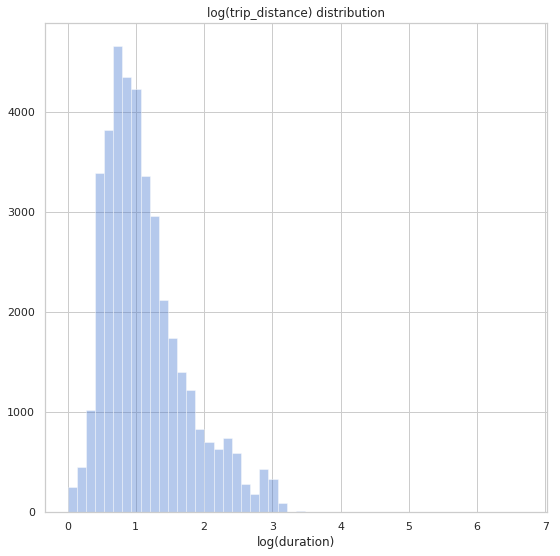

In [23]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.distplot(np.log(train_df['trip_distance'] + 1),
             ax=ax,
             axlabel='log(duration)',
             kde=False)

plt.title('log(trip_distance) distribution');

In [24]:
train_df.columns

Index(['record_id', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'duration',
       'month', 'week_of_year', 'day_of_month', 'day_of_week', 'hour',
       'week_hour', 'manhattan', 'bearing', 'haversine'],
      dtype='object')

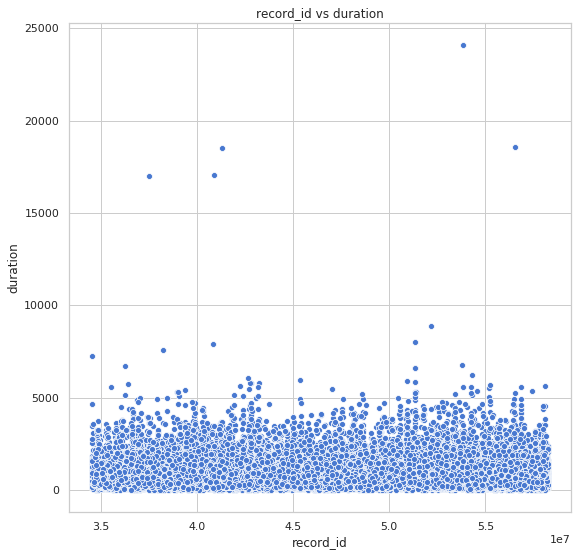

In [25]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x = 'record_id', y = 'duration', data = train_df)
plt.title('record_id vs duration');

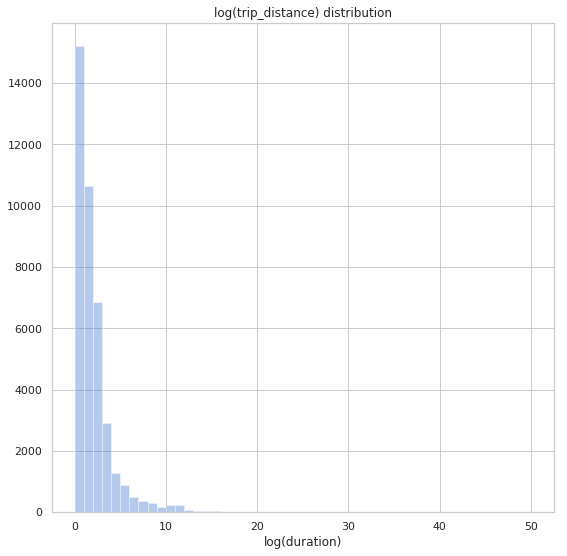

In [26]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.distplot(train_df['tip_amount'],
             ax=ax,
             axlabel='log(duration)',
             kde=False)

plt.title('log(trip_distance) distribution');

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**